In [1]:
import time 
import getdist
import emcee
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.interpolate import interp1d
from scipy.integrate import quad, odeint
from getdist import plots, MCSamples
from astropy.convolution import Gaussian1DKernel
%matplotlib inline

#  page,eta from IDL inversely calibrate local SN

In [2]:
IDL = emcee.backends.HDFBackend("../Chains/IDL=HFSN+2DBAO+CC/PAge.h5",
                                read_only=True)
tau = IDL.get_autocorr_time()
burnin = int(2 * np.max(tau))
thin = int(0.5 * np.min(tau))

flatchainIDL = IDL.get_chain(discard=burnin, flat=True, thin=thin)

In [3]:
# read the SN data

Pantheonplus_Data = pd.read_csv("../Data/Pantheon+SH0ES.dat", sep='\s+')

Pantheonplus_Data = Pantheonplus_Data[["CID", "zHD", "zCMB", "zHEL", "m_b_corr", 
                                                                     "CEPH_DIST", "IS_CALIBRATOR",
                                                                     "USED_IN_SH0ES_HF"]]

Pantheonplus_covariance = pd.read_csv("../Data/Pantheon+SH0ES_STAT+SYS.cov",
                                                                  sep='\s+').values.reshape(1701, 1701)

local_SN = Pantheonplus_Data.query("zHD<0.0233")

ndim = local_SN.shape[0]
SN_cov = np.zeros((ndim, ndim))
SN_cov_index = local_SN.index
SN_cov = np.array([Pantheonplus_covariance[SN_cov_index[i], SN_cov_index[j]]
                                for i in range(0, ndim) for j in range(0, ndim)
                                ]).reshape(ndim, ndim)

inverse_SN_cov = np.matrix(SN_cov).I


class PAge():
    c = 2.998e5  #km/s/Mpc

    def __init__(self, page=None, eta=None):
        self.page = page
        self.eta = eta
        self.set_background()

    def set_background(self):
        self.tlist = np.linspace(0.01, 1.3, 100)
        self.alist = self.aoft(self.tlist)
        self.zlist = 1 / self.alist - 1
        self.tofa = interp1d(self.alist, self.tlist, kind='cubic')  #calculate the t and a relation of PAge
        self.tofz = interp1d(self.zlist, self.tlist, kind='cubic')
        self.Hlist = self.Hoft(self.tlist)
        self.Hofz = interp1d(self.zlist, self.Hlist, kind='cubic')

    def Hoft(self, t):
        page, eta = self.page, self.eta
        return 1 + (2. / 3.) * (1 - eta * t / page) * (1. / t - 1. / page)

    def aoft(self, t):
        page, eta = self.page, self.eta
        return (t / page)**(2.0 / 3.0) * np.exp(eta / 3.0 *
                                                ((t / page)**2 - 1) +
                                                (page - (2.0 / 3.0) *
                                                 (1.0 + eta)) *
                                                (t / page - 1.0))

    def chi(self, z):

        inverse_a = lambda t: 1 / self.aoft(t)

        t0 = self.page
        tz = self.tofa(1 / (1 + z))
        Integral = -quad(inverse_a, t0, tz)[0]
        return Integral

    def Comoving_distance(self, zcmb):

        if ((type(zcmb) == np.ndarray) |
            (type(zcmb) == pd.core.series.Series)):
            I = np.array([self.chi(nz) for nz in zcmb])
        else:
            I = self.chi(zcmb)

        res = I
        return res

    def dL(self, zcmb):
        return (1 + zcmb) * self.Comoving_distance(zcmb)

    def calc_aB(self, SN_z_data, inver_cov):

        dL_vector = np.matrix(
            [np.log10(self.dL(zn)) for zn in SN_z_data["zHD"].values])

        mB_vector = np.matrix(0.2 * SN_z_data["m_b_corr"].values)

        delta_vector = dL_vector - mB_vector

        aB = np.sum(inver_cov * delta_vector.T) / np.sum(inver_cov)

        return aB


"""
Here is inverse calibration chain, only need to run once
"""
#aB_page_eta_IDL = np.array([PAge(page, eta).calc_aB(local_SN, inverse_SN_cov) for page, eta in tqdm(flatchainIDL[:, -2:])])
#np.save("../Figure3/aB_page_eta_IDL.npy", aB_page_eta_IDL)

'\nHere is inverse calibration chain, only need to run once\n'

In [4]:
def calculate_aB(path):

    chain = emcee.backends.HDFBackend(path, read_only=True)
    tau = chain.get_autocorr_time()
    burnin = int(2 * np.max(tau))
    thin = int(0.5 * np.min(tau))

    flatchain = chain.get_chain(discard=burnin, flat=True, thin=thin)[:, :2]

    H0_chain = flatchain[:, 0]
    MB_chain = flatchain[:, 1]
    aB = -0.2 * (MB_chain + 25 - 5 * np.log10(H0_chain) +
                 5 * np.log10(2.998e5))

    return aB

In [5]:
IDL = calculate_aB("../Chains/IDL=HFSN+2DBAO+CC/PAge.h5")
MB_IDL = calculate_aB("../Chains/MB(IDL)+LocalSN/PAge.h5")
MB_SH0ES_HFSN = calculate_aB("../Chains/MB(SH0ES)+HFSN/PAge.h5")
MB_SH0ES_localSN = calculate_aB("../Chains/MB(SH0ES)+LocalSN/PAge.h5")

page_eta_IDL = np.load("aB_page_eta_IDL.npy")

In [6]:
# params = tuple(['a_B'])
# IDL_aB = MCSamples(samples=IDL, names=params, labels=params)
# MB_IDL_aB = MCSamples(samples=MB_IDL, names=params, labels=params)
# MB_SH0ES_HFSN_aB = MCSamples(samples=MB_SH0ES_HFSN,
#                              names=params,
#                              labels=params)
# MB_SH0ES_localSN_aB = MCSamples(samples=MB_SH0ES_localSN,
#                                 names=params,
#                                 labels=params)
# page_eta_IDL_aB = MCSamples(samples=page_eta_IDL, names=params, labels=params)

In [7]:
k = Gaussian1DKernel(4)

def Gaussian_processing(chain, bins):
    prob, aB = np.histogram(chain, bins=bins, range=None)
    prob = np.convolve(prob, k, mode='same')
    prob = prob/prob.max()
    return prob, aB[1:]

In [8]:
IDL_probabilitydensity= Gaussian_processing(IDL, 100)
MB_IDL_probabilitydensity = Gaussian_processing(MB_IDL, 100)
page_eta_IDL_probabilitydensity = Gaussian_processing(page_eta_IDL, 100)
MB_SH0ES_HFSN_probabilitydensity = Gaussian_processing(MB_SH0ES_HFSN, 100)
MB_SH0ES_localSN_probabilitydensity = Gaussian_processing(MB_SH0ES_localSN, 100)

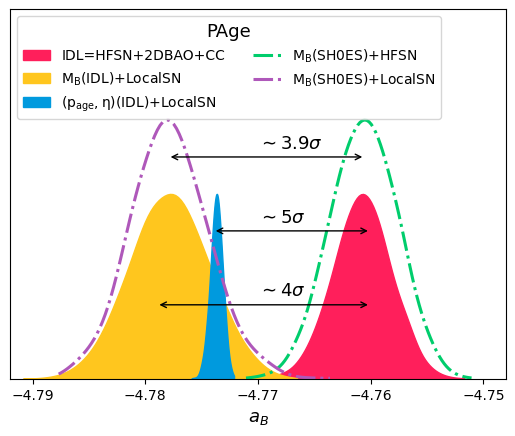

In [9]:
plt.fill_between(IDL_probabilitydensity[1],
                 IDL_probabilitydensity[0],
                 y2=0,
                 color='#FF1F5B',
                 alpha=1)

plt.fill_between(MB_IDL_probabilitydensity[1],
                 MB_IDL_probabilitydensity[0],
                 y2=0,
                 color='#FFC61E',
                 alpha=1)

plt.fill_between(page_eta_IDL_probabilitydensity[1],
                 page_eta_IDL_probabilitydensity[0],
                 y2=0,
                 color='#009ADE',
                 alpha=1)

plt.plot(MB_SH0ES_HFSN_probabilitydensity[1],
         MB_SH0ES_HFSN_probabilitydensity[0] * 1.4,
         color='#00CD6C',
         lw=2.2,
         linestyle='-.')

plt.plot(MB_SH0ES_localSN_probabilitydensity[1],
         MB_SH0ES_localSN_probabilitydensity[0] * 1.4,
         color='#AF58BA',
         lw=2.2,
         linestyle='-.')

plt.legend(labels=[
    'IDL=HFSN+2DBAO+CC',
    r'$\mathrm{M_B}$(IDL)+LocalSN',
    r'($\mathrm{p_{age}, \eta}$)(IDL)+LocalSN',
    r'$\mathrm{M_B}$(SH0ES)+HFSN',
    r'$\mathrm{M_B}$(SH0ES)+LocalSN',
],
           loc='upper left',
           title='PAge',
           fontsize=10,
           title_fontsize=13,
           ncol=2)

plt.annotate(text='',
             xy=(-4.774, 0.8),
             xytext=(-4.760, 0.8),
             arrowprops=dict(arrowstyle='<->'))
plt.annotate(text='$\sim5\sigma$',
             xy=(-4.77, 0.85),
             xytext=(-4.77, 0.85),
             arrowprops=None,
             fontsize=13)

plt.annotate(text='',
             xy=(-4.7790, 0.4),
             xytext=(-4.760, 0.4),
             arrowprops=dict(arrowstyle='<->'))
plt.annotate(text='$\sim4\sigma$',
             xy=(-4.77, 0.45),
             xytext=(-4.77, 0.45),
             arrowprops=None,
             fontsize=13)

plt.annotate(text='',
             xy=(-4.7780, 1.2),
             xytext=(-4.7605, 1.2),
             arrowprops=dict(arrowstyle='<->'))
plt.annotate(text='$\sim3.9\sigma$',
             xy=(-4.77, 1.25),
             xytext=(-4.77, 1.25),
             arrowprops=None,
             fontsize=13)

plt.xticks(np.arange(-4.8, -4.7, 0.01), fontsize=10)
plt.yticks([])
plt.xlim(-4.792, -4.748)
plt.ylim(0, 2)
plt.xlabel("$a_B$", fontsize=13)
plt.savefig("PAge-aB-probility.pdf", dpi=1000, bbox_inches='tight')